# Main Notebook: NLP Series Workshop 2: Diving Deeper into Sentiment Analysis Techniques

## Table of Contents
<div class="alert alert-block alert-info">
<ol>
    <li>
      <a href="#scrollTo=Setup_and_Exploration">Setup and Exploration</a>
      <ol type="a">
          <li><a href="#scrollTo=a_Setup">Setup</a></li>
          <li><a href="#scrollTo=b_Exploration">Exploration</a></li>
      </ol>
    </li>
    <li>
      <a href="#scrollTo=Preprocessing">Preprocessing</a>
      <ol type="a">
          <li><a href="#scrollTo=a_Dataset_Modifications">Dataset Modifications</a></li>
          <li>
            <a href="#scrollTo=b_Data_Cleaning">Data Cleaning</a>
            <ol type="i">
              <li><a href="#scrollTo=i_Stop_Words">Stop Words</a></li>
              <li><a href="#scrollTo=ii_Stemming">Stemming</a></li>
              <li><a href="#scrollTo=iii_One_Hot_Encoding">One-Hot Encoding</a></li>
            </ol>
          </li>
      </ol>
    </li>
    <li>
      <a href="#scrollTo=Modeling">Modeling</a>
      <ol type="a">
          <li><a href="#scrollTo=a_Intro_to_Bag_of_Words">Intro to Bag of Words</a></li>
      </ol>
    </li>
    <li>
      <a href="#scrollTo=Modeling">Training</a>
      <ol type="a">
          <li><a href="#scrollTo=a_Intro_to_Bag_of_Words">Intro to Bag of Words</a></li>
      </ol>
    </li>
    <li><a href="#scrollTo=Conclusion">Conclusion</a></li>
</ol>
</div>

Credit to this wonderful notebook which we used as a basis for this workshop: https://www.kaggle.com/code/dorgavra/emotion-classification-nlp/notebook

<span style="color:red">__DISCLAIMER__</span> : This dataset contains hateful speech and explicit content. 

Conventions used:

❗ - Required <br>
❓ - Question <br>

# 1. Setup and Exploration

## a. Setup

The dataset we'll use can be found here: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [182]:
import gdown
!mkdir -p /content/emotion-sentiment
%cd /content/emotion-sentiment
gdown.download('https://drive.google.com/uc?export=download&id=1qkkiX1X5udWEUxbBBLKPH-xMP_upG0QX')
!unzip -q archive.zip
!rm archive.zip

/content/emotion-sentiment


Downloading...
From: https://drive.google.com/uc?export=download&id=1qkkiX1X5udWEUxbBBLKPH-xMP_upG0QX
To: /content/emotion-sentiment/archive.zip
100%|██████████| 738k/738k [00:00<00:00, 70.9MB/s]


replace test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


__BACKUP CELL__: If (*and only if*) you are unable to download with the above cell:
1. [download the dataset](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)
2. unzip on your machine
3. run the cell below
4. upload `test.txt`, `val.txt`, and `train.txt`

In [183]:
# from google.colab import files
# !mkdir -p /content/emotion-sentiment
# %cd /content/emotion-sentiment
# files.upload() # upload test.txt
# files.upload() # upload val.txt
# files.upload() # upload test.txt

Import Libraries

In [184]:
import re
import nltk
import numpy as np
import pandas as pd

from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Dense, SimpleRNN, Embedding, Flatten, Dropout

Load Datasets with Pandas

In [185]:
test_data = pd.read_csv("/content/emotion-sentiment/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("/content/emotion-sentiment/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("/content/emotion-sentiment/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

## b. Exploration

❓: What are train, validation, and test data?

The creator of this Kaggle dataset split the data into 3 parts: train (for training our model), validation (for checking how well our model performs), and test (for seeing how our model performs on wild data).

Let's examine our Train, Validation, and Test data. First, we'll look at size.

In [186]:
print("Train size:\t", train_data.shape)
print("Test size:\t", test_data.shape)
print("Validation:\t", validation_data.shape)

Train size:	 (16000, 2)
Test size:	 (2000, 2)
Validation:	 (2000, 2)


Let's now look at the contents of our train data:

In [187]:
train_data

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


❓: What do you notice about our dataset?

1. We have a "comment", which is a sentence indicating someone's emotional state.
  - This seems like the natural language data our model will read.
2. We have a corresponding "emotion" label which categorizes the emotion.
  - This seems like the labels our model will learn to attribute to setences.


We now find all "emotion" labels in our data:

In [188]:
print(train_data['Emotion'].unique())

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


We have 6 "emotion" classes; so, we'll be training a model for *multi-class classification*.

❓: What is __multi-class classification__?

> __multi-class classification__ : classifying instances into more than two classes

# 2. Preprocessing

## a. Dataset Modifications

First, we'll add a column names "Length" to the `train_data` table which will hold the length of each sentence.

In [189]:
train_data['Length'] = [len(x) for x in train_data['Comment']]

Second, we're going to replace the emotion names with integers.

So, 'sadness', 'anger', 'love', 'surprise', 'fear', and 'joy' will be replaced with integers from 0 to 5. We will use sk-learn's `LabelEncoder()` class to do this.

In [190]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

Now let's take a look at the modified `train_data` table.

In [191]:
train_data

,Comment,Emotion,Length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


## b. Data Cleaning

Now, let's clean our text data.

❓: What do you think "cleaning" the data means?

We want to
1. remove excess from our data
2. make the data readable by a computer

### i. Stop Words

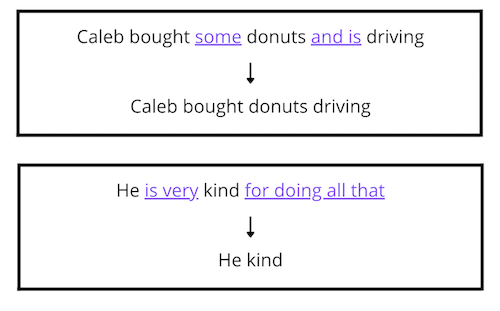

In [192]:
sentences = ['Caleb bought some donuts and is driving', 'He is very kind for doing all that']

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print()

for sentence in sentences:
  stopped = " ".join([word for word in sentence.split() if word not in stopwords])
  print(f"{sentence}\n{stopped}\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

Caleb bought some donuts and is driving
Caleb bought donuts driving

He is very kind for doing all that
He kind



### ii. Stemming

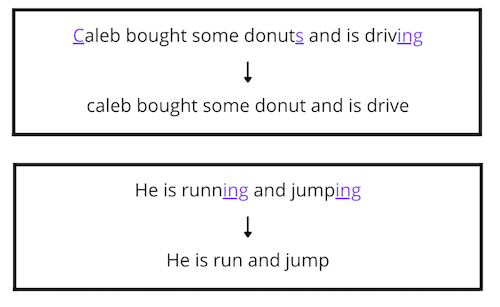

In [193]:
sentences = ['Caleb bought some donuts and is driving', 'He is running and jumping']

stemmer = PorterStemmer()

for sentence in sentences:
  stemmed = " ".join([stemmer.stem(word) for word in sentence.split()])
  print(f"{sentence}\n{stemmed}\n")

Caleb bought some donuts and is driving
caleb bought some donut and is drive

He is running and jumping
He is run and jump



### iii. One-Hot Encoding

Note that this is not a standard form of one-hot encoding. However, TensorFlow Keras has a function, `one_hot()`, which functions in the below manner.

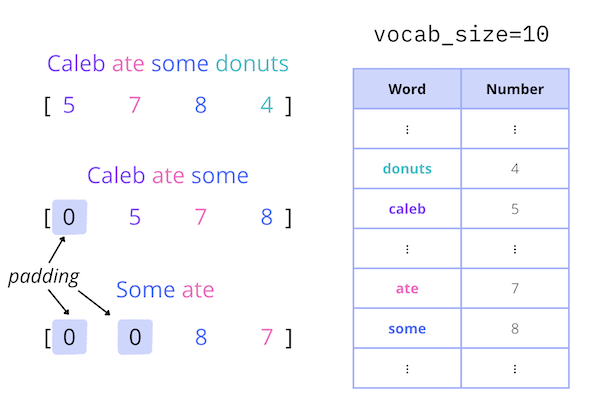

In [223]:
sentences = ['Caleb ate some donuts', 'Caleb ate some', 'Some ate']

max_len = max([len(sentence.split()) for sentence in sentences])

encoded = []
for sentence in sentences:
  encoded.append(one_hot(input_text=sentence, n=10, lower=True))

padded = pad_sequences(sequences=encoded,maxlen=max_len,padding='pre')

for i in range(len(padded)): print(f"{sentences[i]}\n{padded[i]}\n")

Caleb ate some donuts
[5 7 8 4]

Caleb ate some
[0 5 7 8]

Some ate
[0 0 8 7]



We will incorporate the above techniques into a function `text_cleaning()`

This function is really complex, so we won't cover every single little detail. At a high level, we:
1. remove special characters
2. convert everything to lowercase
3. remove stop words
4. stem our data
5. apply one-hot encoding

In the end, we are just trying to convert the data (both the tweets and the labels) into a format acceptable for training the model. This is the essence of __preprocessing__.

In [224]:
vocab_size = 11000                  # decide that vocab length will be 11000
max_len=train_data['Length'].max()  # get max length of a word

# we will download our stopwords from nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_cleaning(df, column):

  """Removing unrelevent chars, Stemming and padding"""
  stemmer = PorterStemmer()
  corpus = []
  
  for text in df[column]:
    # remove special characters
    text = re.sub("[^a-zA-Z]", " ", text)

    # convert to lowercase
    text = text.lower()

    # stem words with stemmer and remove stop words with nltk                                    
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)

    corpus.append(text)

  # one-hot encode each sentence; converts each sentence to a vector
  one_hot_word = [one_hot(input_text=sentence, n=vocab_size) for sentence in corpus]

  # makes all vectors the same length
  pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')

  return pad

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now that we have our `text_cleaning()` function, we can apply it to our train, validation, and test data.

In [225]:
x_train = text_cleaning(train_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")
x_test = text_cleaning(test_data, "Comment")

In [226]:
print(x_train)
print(x_train.shape)

[[   0    0    0 ... 6984  672 4749]
 [   0    0    0 ... 1604 3444 4163]
 [   0    0    0 ...  672 4064 3956]
 ...
 [   0    0    0 ... 6997  706 6613]
 [   0    0    0 ... 1824 2424 9885]
 [   0    0    0 ...  672  158 7253]]
(16000, 300)


`x_train` is a collection of vectors; each vector represents a sentence in our train dataset.


`x_train` has 16000 vectors, while `x_test` and `x_val` have 2000 vectors each.

Now we create `y_train`, `y_val`, and `y_test` out of the emotion labels.

In [240]:
y_train_nums = train_data["Emotion"]
y_val_nums = validation_data["Emotion"]
y_test_nums = test_data["Emotion"]

y_train = to_categorical(y_train_nums)
y_val = to_categorical(y_val_nums)
y_test = to_categorical(y_test_nums)

print("As Numbers:\n" + str(y_train_nums.head(5)))
print()
print("As Vectors:\n" + str(y_train[0:5]))

As Numbers:
0    4
1    4
2    0
3    3
4    0
Name: Emotion, dtype: int64

As Vectors:
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


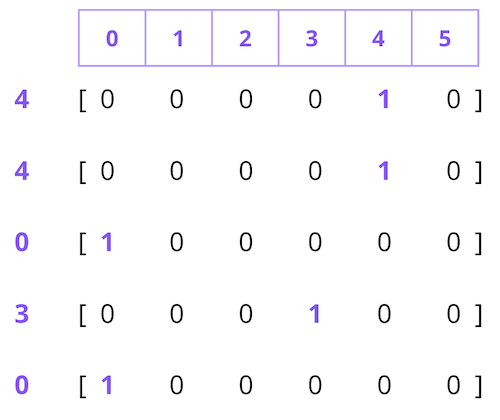

`to_categorial()` applies a more traditional form of one-hot encoding to convert all "emotion" label values to vector represenations.

In [241]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(16000, 6)
(2000, 6)
(2000, 6)


`y_train` has 16000 vectors, while `y_test` and `y_val` have 2000 vectors each.

We now have cleaned data, split across `x_train`, `x_test`, and `x_val`, along with our labels in `y_train`, `y_val`, and `y_test`. We are ready to begin making our model!

# 3. Modeling an RNN

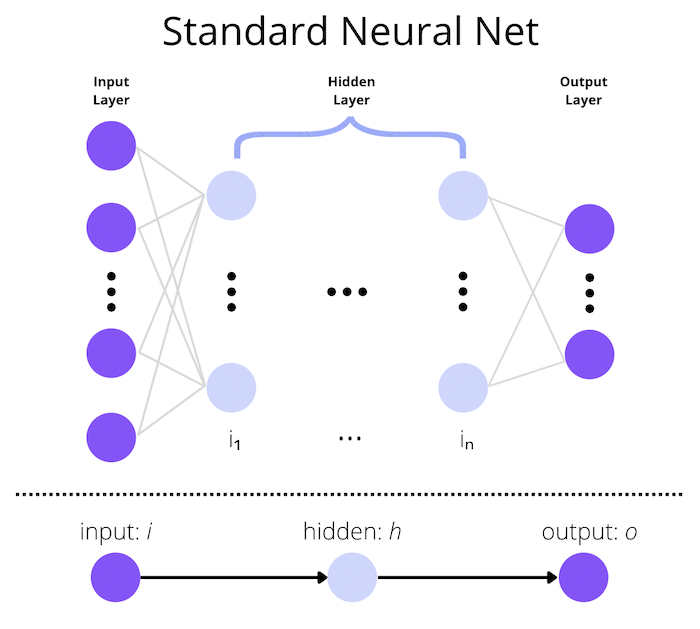

❓: What is __Sequential Data__?

> __Sequential Data__ : a dataset where data points rely on other data points

For example, sentences are a form of *sequential data*; each word's meaning depends on the other words in the sentence for context.

❓: What is __Recurrent Neural Network (RNN)__?

> __Recurrent Neural Network (RNN)__ : An RNN is a special type of neural network built to process sequential data; it is a model with its own internal memory

RNNs processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

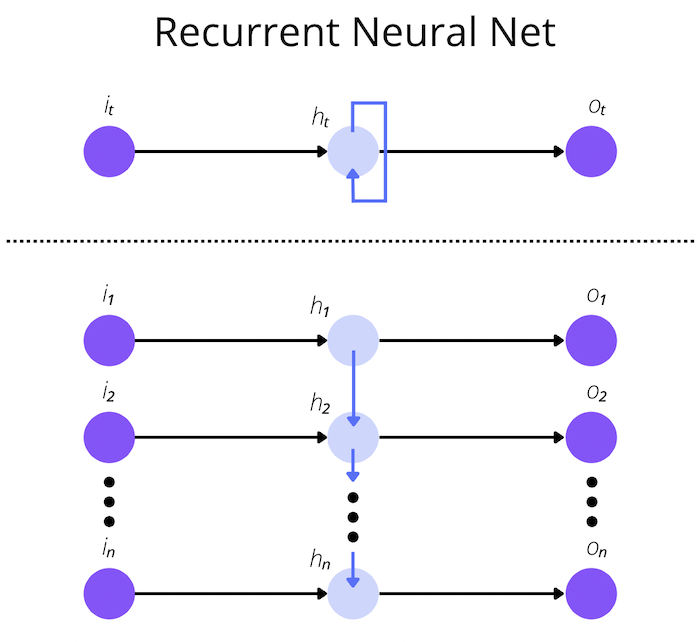

RNNs are advantageous in NLP because they are able to recognize a sequence of words rather than just the individual words in the tweet.
 
i.e. We can use an RNN model to understand sentences in the tweets!

The following code creates the model and adds layers to it.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(SimpleRNN(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

❓ What does the dropout layer do?

# 4. Training

## Now we will train the model!

### Some arguments to know about:

**x_train:** training tweets <br>
**y_train:** labels (emotion) of the training tweets <br>
**epochs:** number of times the model will go through the dataset <br>
**batch_size:** number of training samples that go through the model in each epoch

In [ ]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1)

In [ ]:
model.save_weights('w2_checkpoint')

In [ ]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 3s 46ms/step - loss: 0.5504 - accuracy: 0.8440


[0.550441324710846, 0.843999981880188]

In [ ]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 3s 51ms/step - loss: 0.5514 - accuracy: 0.8330


[0.5513563752174377, 0.8330000042915344]

Looks like our model is 84% accurate on the validation data and 83% accurate on the test data.

# 4. Conclusion